<b><FONT size="9" color='navy'>Timeseries anaylsis</FONT>
> <b><FONT size="6" color='olive'>Groupe : Fancello Marie Clara, Germini Eva, Gutfreund Eloise</FONT>
>> <b><FONT size="4" color='teal'>Le projet vise à analyser l'impact d'un choc d'inflation sur l'économie américaine ainsi que sur les actions et les taux américains.</FONT>

In [2]:
# Chargez ici les librairies dont vous avez besoin
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import statsmodels.api as sm

import seaborn as sns

from scipy.optimize import minimize
from scipy.stats import norm

from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

In [3]:
# Loadez ici les données fournies pour le sujet
df = pd.read_csv("Data_project.csv", sep=";", decimal=",", parse_dates=["dates"],index_col=["dates"])

# Regard des cinq premières lignes du dataframe 
df.head()

,Inflation,Fed Fund Rate,GDP,10-year real rates,Value,Market
dates,,,,,,
1963-03-31,0.004279,0.0012,0.011221,"0,028230527",0.0190,0.0308
1963-06-30,0.003278,0.0000,0.021984,"0,026759351",0.0077,-0.0200
1963-09-30,0.003594,0.0050,0.006556,"0,030838067",0.0008,-0.0157
1963-12-31,0.005208,0.0000,0.021083,"0,024941804",-0.0008,0.0183
1964-03-31,0.001943,0.0000,0.010887,"0,02820626",0.0336,0.0141


In [4]:
# Dimension de la base de données 
print("Dimensions de la base de données : \n")
print(df.shape, "\n")

# On verifie que les données ont le bon type 
print("Type des variables : \n")
print(df.dtypes)

Dimensions de la base de données : 

(235, 6) 

Type des variables : 

Inflation             float64
Fed Fund Rate         float64
GDP                   float64
10-year real rates     object
Value                 float64
Market                float64
dtype: object


**Types:** 
- Le variable numériques "10-year real rates" est en object. 
- La variable "dates" est également de type object. 

In [5]:
# Remplacement de "," par des "." dans 10-year real rates 
def treatment(row):
    row = row.replace(',','.')
    return row
df['10-year real rates']=df['10-year real rates'].apply(treatment)

# Remplacement des valeurs manquantes par des NA reconnue de python 
def pro(row):
    if row=="#VALEUR!":
        row=np.nan
    return row
df['10-year real rates']=df['10-year real rates'].apply(pro)

# Changement du type 
df['10-year real rates']=df['10-year real rates'].astype("float")

# On verifie que les donnees ont le bon type 
print("Type des variables : \n")
df.dtypes

Type des variables : 



Inflation             float64
Fed Fund Rate         float64
GDP                   float64
10-year real rates    float64
Value                 float64
Market                float64
dtype: object

> <b><FONT size="4" color='teal'>Analyse graphique des séries </FONT>

In [6]:
# affiche le nom des variables
df.columns

Index(['Inflation', 'Fed Fund Rate', 'GDP', '10-year real rates', 'Value',
       'Market'],
      dtype='object')

**Graphiques**
<br/> A première vue, les variables semblent stationnaires. 

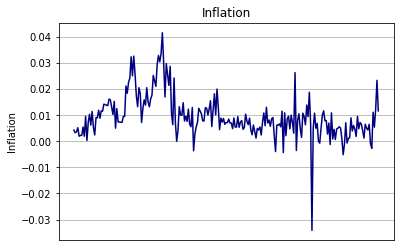

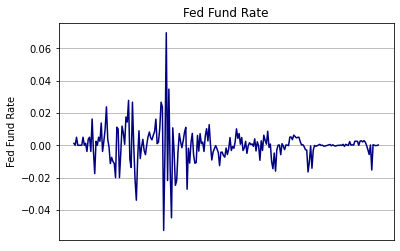

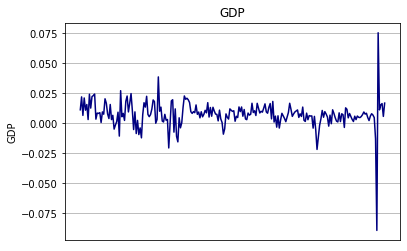

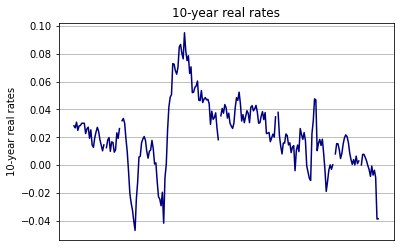

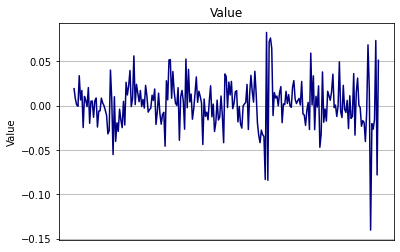

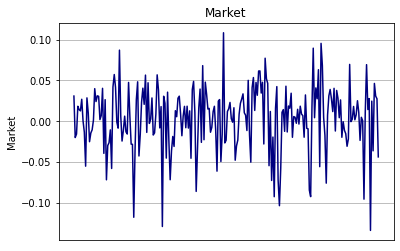

In [7]:
# Première analyse graphique des séries
liste =['Inflation', 'Fed Fund Rate', 'GDP', '10-year real rates','Value', 'Market']

for a in liste: 
    fig, ax = plt.subplots()
    ax.plot(df[a],  color="navy")
    #ax.set_adjustable('box')
    #ax.set_xticks(np.arange(0, len(df['dates'])+1,5))
    plt.grid(True)
    plt.ylabel(a)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    plt.title(a)
    plt.show()
    fig.savefig(a+'serie.pdf')

> <b><FONT size="4" color='teal'>Analyse des valeurs manquantes </FONT>

In [8]:
# On regarde si les donnees presentent des valeurs manquantes
df.isna().sum()

Inflation             0
Fed Fund Rate         0
GDP                   0
10-year real rates    6
Value                 0
Market                0
dtype: int64

In [9]:
# Et observe ou sont ces valeurs manquantes 
is_missing = df[df['10-year real rates'].isna()==True]
is_missing

,Inflation,Fed Fund Rate,GDP,10-year real rates,Value,Market
dates,,,,,,
1969-03-31,0.014045,0.0100,0.003040,NaN,-0.0052,0.0264
1972-03-31,0.007299,-0.0050,0.022698,NaN,-0.0163,0.0063
1991-03-31,0.004471,-0.0126,0.007797,NaN,-0.0130,0.0265
2002-03-31,0.006201,-0.0028,0.006155,NaN,0.0107,0.0424
2013-03-31,0.004589,-0.0002,0.001394,NaN,-0.0023,0.0403
2018-03-31,0.007189,0.0026,0.008339,NaN,-0.0023,-0.0235


> La variable 10 year real rates présente 6 valeurs manquantes pour le premier trimestre des années 1969, 1972, 1991, 2002, 2013 et 2018. Cependant, nous disposons d'autres données du premier trimestre pour cette variable.  

> Afin de remplacer ces valeurs manquantes, plusieurs options s'offrent à nous. Nous pourrions les remplacer par la moyenne ou la médiane, mais cela ne tiendrait pas compte des variations trimestrielles que nous pouvons observer sur cette base de donnée, et enlève donc de l'information. Il serait également possible de remplacer la valeur manquante par la valeur précédente (par exemple prendre la valeur de 10 year real rates au 1968-12-31 comme valeur pour la date du 1969-03-31). Cependant, cela crérait un choc entre le dernier trimestre de l'année t-1 et le deuxième trimestre de l'année t. Ce choc serait d'autant plus important que la valeur au dernier trimestre de l'année t-1 serait différente du premier trimestre de l'année t.  

> Nous décidons donc de procéder à une interpolation linéaire, qui permet d'estimer la valeur manquante en fonction des valeurs précédentes et suivantes. 

In [10]:
# Changement des NaN via une interpolation linéaire 
df['10-year real rates'] = df['10-year real rates'].interpolate()

# Verificaiton
df.isna().sum()

Inflation             0
Fed Fund Rate         0
GDP                   0
10-year real rates    0
Value                 0
Market                0
dtype: int64

<b><FONT size="6" color='navy'>Partie 1 - Estimation des surprises d'inflation (8 points)</FONT>

> <b><FONT size="4" color='teal'>Question 1</FONT>

>> Faites apparaitre l'ACF et la PACF de chacune des variables présentes dans votre jeu de données. Décrivez ce que vous voyez et quelles sont les conclusions que vous en tirez.

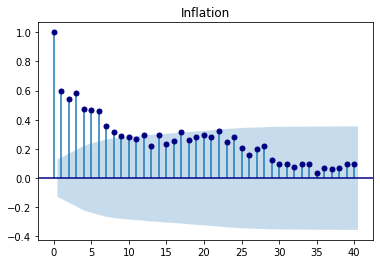

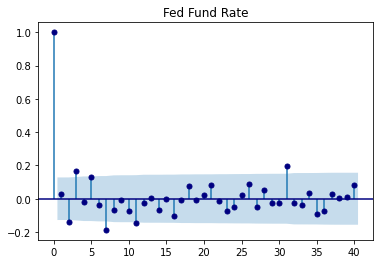

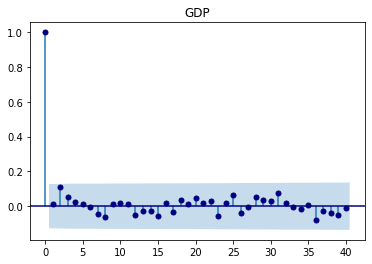

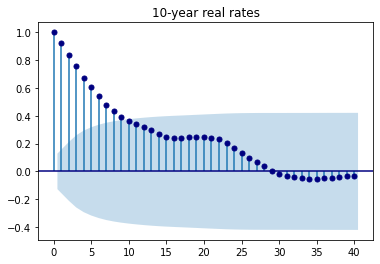

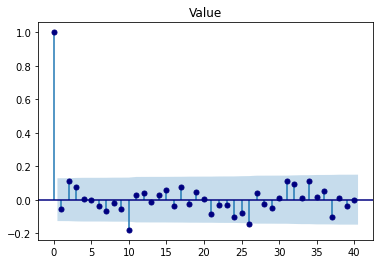

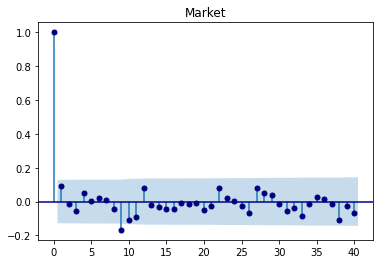

In [11]:
# Plot des ACF
for a in liste:
    sm.graphics.tsa.plot_acf(df[a].dropna(), title=a, lags=40, color="navy")
    plt.show()

- Via l'ACF de la variable d'inflation, on constate que les valeurs actuelles de l'inflation sont fortement corrélées aux valeurs passées de la série. En effet, les corrélations restent supérieures ou égales à 0.5 jusqu'au 6 ème lags. Elles sont significative jusqu'au lag 8. Par extension, l'autocorrélogramme est décroissant, indiquant un processus autoregressif. 
- La variable Fed Fund Rate a des autocorrélations significatives aux lags 2, 3 et 5.
- Les variables GDP, Value et market ne sont pas autocorrélées. 
- Finalement, la variable 10-year real rates est autocorrélée à ses valeurs passées significativement jusqu'au lag 9. L'autocorrélogramme est également décroissant de façon rapide, indiquant une série à mémoire courte. 

Finalement, les autocorrélogrammes décroissants et alternant valeurs positives et négatives indiquent que les séries sont stationnaires. 

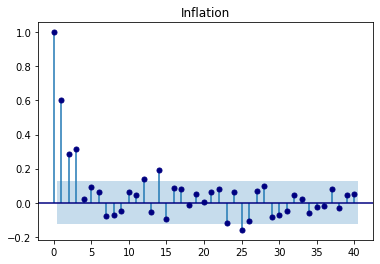

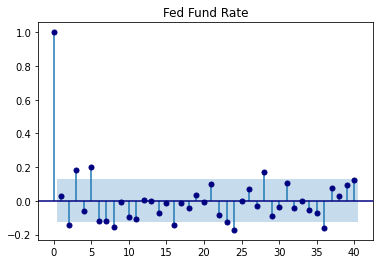

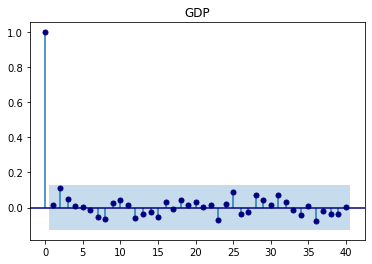

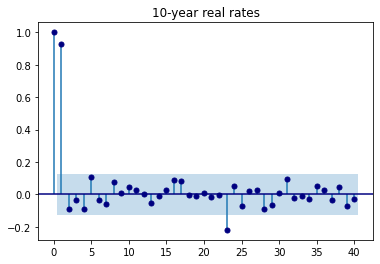

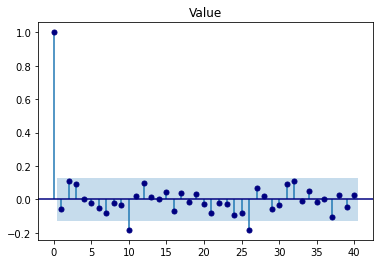

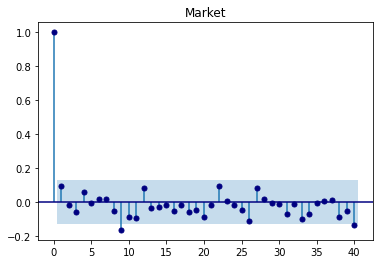

In [12]:
# Plot des PACF
for a in liste:
    sm.graphics.tsa.plot_pacf(df[a].dropna(), title=a, lags=40, color='navy')
    plt.show()

- En regardant co-jointement l'ACF et la PACF des variables "Inflation" et "10-year real rates", on constate que ces deux variables sont certainement des processus autoregressifs. En effet, les valeurs actuelles dépendent fortement de leurs valeurs passées. La PACF de la variable "Inflation" a 3 lags significatifs indiquant qu'il s'agirait d'un processus AR(3). La PACF de la variable "10-year real estate" indique un seul lag significatif et serait donc un processus autoregressif d'ordre 1. 
- La variable du Fed Fund Rate a également des lags significatifs aux lags 2, 3 et 5 mais le premier lag n'est pas significatif. 

> <b><FONT size="4" color='teal'>Question 2</FONT>
>> En utilisant la vraisemblance codée en cours que vous modifierez en conséquence, estimez par maximum de vraisemblance un modele AR(2) sur les variations trimestrielles de l'inflation.

In [13]:
def ML_criterion_ar2(para,x,plot=False):
    phi0 = para[0]
    phi1 = para[1]
    phi2 = para[2]
    expected = phi0+phi1*x.iloc[0:-1]+phi2*x.iloc[0:-2]
    expected.index = x.index[1:len(x)]
    temp = pd.concat([x,expected],axis=1)
    temp.columns=['initial','fit']
    temp = temp.dropna()
    difference = temp['initial']-temp['fit']
    volatility = np.nanstd(difference)
    loglik = norm.pdf(temp['initial'],temp['fit'],volatility)
    criterion = np.nansum(np.log(loglik))
    if plot == True:
        temp.plot(color = ['navy','teal'])
    return -criterion

-809.3541643596386

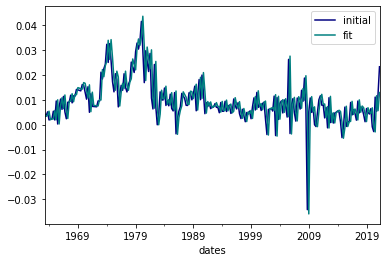

In [14]:
para = [0,0.85,0.2]
ML_criterion_ar2(para,df['Inflation'], plot=True)

L'estimation du modèle étant très proche des données initiales, le modèle estime donc la variable d'intérêt avec une erreur faible.

> <b><FONT size="4" color='teal'>Question 3</FONT>
>> Testez la significativité des paramètres de votre modèle et présentez pour cela un test de Student, comme fait en cours.

In [15]:
# Minimisation de la fonction scalaire via la Méthode de Broyden-Fletcher-Goldfarb-Shanno 
x0 = np.array([1,2,7])
res_EV = minimize(ML_criterion_ar2, x0, method='BFGS', args=(df['Inflation']),hess=True,options={'disp': False})

# On calcule l'écart-type des paramètres
std_para=np.diag(res_EV.hess_inv)**.5

# Et fait le test de student
print(res_EV.x/std_para)

[ 8.39528318 -3.10887091  3.9635615 ]


> Un paramètre est significatif au seuil d'erreur 5% lorsque la statistique du test de student est supérieur à 1.96 en valeur absolue. 

> La t-stat de $\phi_0$ étant égale à 8.4, la constante du modèle est donc significativement différente de 0. Les t-stats de $\phi_1$ et $\phi_2$ sont également supérieures en valeur absolue à 1.96, ces paramètres sont donc significativement différents de 0. 

> Ainsi, nous rejettons l'hypothèse $H_0$ de nullité des paramètres au seuil $alpha = 0.05$. 

> <b><FONT size="4" color='teal'>Question 4</FONT>
>>Calculez des résidus de votre regression et représentez les graphiquement, ainsi que leur somme cumulée en fonction des dates. Que voyez vous? Nous appelerons les résidus non-cumulés "surprise d'inflation". Pourquoi?

In [16]:
# calcule l'inflation estimée
phi0 = res_EV.x[0]
phi1 = res_EV.x[1]
phi2 = res_EV.x[2]
y_hat = phi0+phi1*df['Inflation'].iloc[0:-1]+phi2*df['Inflation'].iloc[0:-2]

y = df['Inflation']
# calcule des résidus entre l'inflation réelle et l'inflation estimée
resid = y-y_hat
residus = pd.DataFrame(resid)
residus = residus.rename(columns = {"Inflation": "residus_inflation"})

# Calcul de la somme cumulée des résidus 
residus['residus_cumules'] = residus['residus_inflation'].cumsum()
residus = residus.dropna() 
residus.head()

,residus_inflation,residus_cumules
dates,,
1963-03-31,-0.002096,-0.002096
1963-06-30,-0.002492,-0.004587
1963-09-30,-0.002367,-0.006954
1963-12-31,-0.001728,-0.008682
1964-03-31,-0.003020,-0.011702


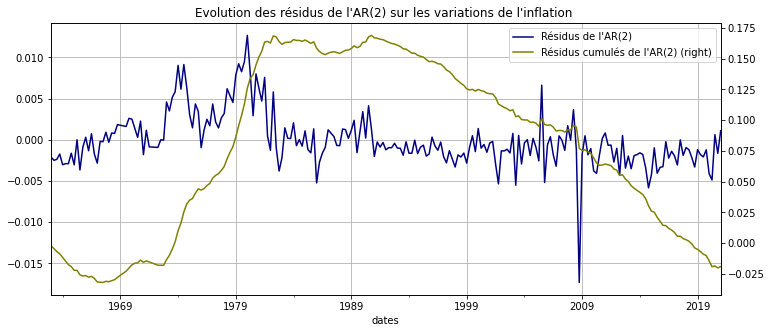

In [17]:
plt.figure(figsize=(12,5))
plt.title("Evolution des résidus de l'AR(2) sur les variations de l'inflation ")

ax1 = residus['residus_inflation'].plot(color='navy', grid=True, label="Résidus de l'AR(2)")
ax2 = residus['residus_cumules'].plot(color='olive', grid=True,secondary_y=True, label="Résidus cumulés de l'AR(2)")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

> On appelle les résidus non-cummulés suprise d'inflation car ces résidus sont la différence entre l'inflation réelle, et l'inflation estimée par notre modèle. Plus ces résidus sont élevés à la date t, plus notre estimation de l'inflation est faussée à la date t. Dans un contexte d’accroissement de l’utilisation de modélisation dans le secteur financier et bancaire, il est important de s'interroger sur les risques liés à cette pratique. Un modèle est par définition une représentation simplifiée de la réalité. Son caractère schématique suppose donc qu’il existe un écart entre le résultat modélisé et la réalité observée. Ainsi, lorsqu’un choc impacte l’économie, l’écart entre l’estimation et la réalité s’accentue.

> Sur le graphique ci-dessus, nous observons en bleu les surprises d'inflation, et en vert les résidus cumulés. Le graphique a deux axes, celui de droite va de -0.025 à 0.175 est concerne les résidus cumulés. L'axe de gauche va de -0.015 à 0.01 est concerne les suprises d'inflation. 

> On constate que les surpises d'inflation suivent les variations de l'inflation observée : leur pic le plus élevé est au premier trimestre de 1980 lors de la fin de la période de grande inflation américaine. Pour lutter contre cette inflation a 14,5% Paul Volcker (président de la Fed de 1979 à 1987) a augmenté le taux directeur de 9pts, ce dernier passant de 11% à 20%. On constate directement les effets de cette mesure sur le taux d'inflation, et sur les suprises d'inflation également.
> Le pic de suprise d'inflation plus faible est au dernier trimestre de 2008, lors de la crise des subprimes. Cette dernière a en partie été causée par des prêts hypothécaires accordés à des gens insolvables et donc dans l'incapacité de rembourser, engendrant une augmentation du nombre de logements sur le marché. Cette mesure est venue augmenter l'offre de biens, tout en ayant une demande indique voire plus faible et a donc baissé l'inflation de façon drastique. 

> Cela indique donc que le modèle suit bien les variations de l'inflation, mais minimise ou maximise ses variations. 

<b><FONT size="6" color='navy'>Partie 2 - Estimation d'un modèle VAR (6 points)</FONT>

> <b><FONT size="4" color='teal'>Question 1</FONT>
>> Combinez les données de votre base de donnée hors inflation avec les surprises d'inflation dans un meme DataFrame pandas. Ne prenez pas les taux réels eux-même mais leur différence première. Calculez la matrice de corrélation des données et commentez la.

In [23]:
# Création d'une base hors inflation
df_hors_inf = df.drop(columns = ['Inflation'])

# Concaténation de cette base aux suprirses d'inflation
data = pd.concat([df_hors_inf,residus['residus_inflation']], axis=1)

# Création de la différence première des taux réels 
data['10y_rr_lag'] = data['10-year real rates'].shift(-1)
data['laged_real_rates'] = data['10y_rr_lag']  - data['10-year real rates']  

data = data.drop(columns = ['10-year real rates','10y_rr_lag'])
data = data.dropna()
data.tail()

,Fed Fund Rate,GDP,Value,Market,residus_inflation,laged_real_rates
dates,,,,,,
2020-03-31,0.0002,-0.089373,-0.1402,-0.1338,-0.004116,0.007439
2020-06-30,-0.0153,0.075475,-0.0204,0.0246,-0.004873,-0.006521
2020-09-30,0.0004,0.011153,-0.0266,-0.0363,0.000620,0.003498
2020-12-31,0.0000,0.015339,-0.0156,0.0463,-0.001643,-0.005272
2021-03-31,-0.0002,0.016407,0.0732,0.0308,0.001102,-0.029772


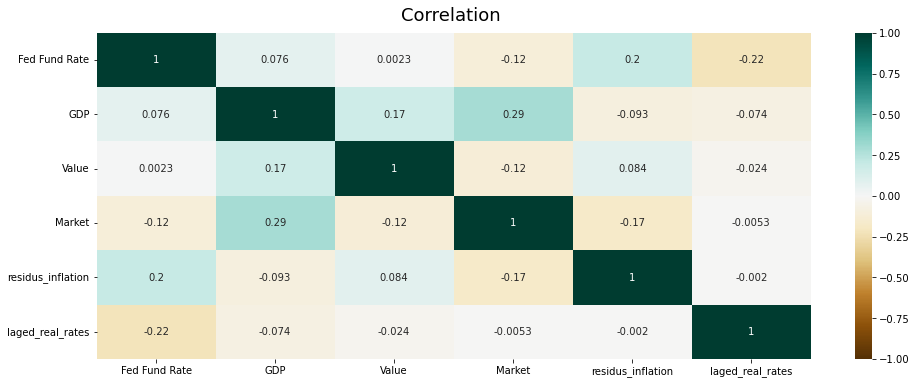

In [26]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation ', fontdict={'fontsize':18}, pad=12);

> Nous nous intéressons premièrement aux corrélations positives. 
>> La variable Makret est corrélée à hauteur de 0.29 avec la variable GDP, ce qui indique une association positive entre le produit interieur brut et les cours des actions. 
> 
>> La variable Fed Fund Rate est corrélée avec les surprises d'inflations. Cela signifie que les mauvaises estimations de l'inflation sont associées positivement aux variations trimestrielles du taux directeur de la FED, ce qui est un résultat attendu. 
Le reste des corrélations positives sont très faibles. 

> Nous nous intéressons à présent aux corrélations négatives. 
>
>> On constate par exemple que les taux réel à 10 ans différenciés sont négativement corrélés au taux directeur de la FED. Ce résultat est également attendu car les taux réels sont les taux d'intérêt auxquels on soustrait l'inflation, 
lorsque les taux de la FED permettent de gérer l'inflation. Mécaniquement, si l’inflation augmente, les taux de la FED vont augmenter afin de la baisser et les taux réels à 10 ans  vont augmenter. Le calcul de différenciation première étant “Taux à 10 ans en t-1” - “Taux à 10 ans en t”, les taux réels différenciés vont baisser dans cet exemple. 


>>  La variable du taux directeur de la FED est également négativement corrélée à la variable Market. Cela est du au fait qu'en cas de crainte d'inflation, le taux directeur va augmenter afin de baisser la consommation et la poussée inflationniste. Cela engendrera donc une augmentation de l'intérêt à investir dans des obligations ces dernières étant moins risquées, et donc une baisse des investissements en actions. Cela explique que ces deux variables soient négativement corrélées. Cependant, il est important de noter que cette corrélation négative est très faible : -0.12. 

> <b><FONT size="4" color='teal'>Question 2</FONT>
>> Commme présenté en cours, estimez un modèle VAR optimal sur votre base de donnée. Prenez soin de définir le meilleur nombre de lag en fonction du bon critère. Discutez la significativité des paramètres.

In [48]:
num_lines = np.size(data,0);
df_updated = np.subtract(data.iloc[1:(num_lines),:],data.iloc[0:(num_lines-1),:])
df_updated = pd.DataFrame(df_updated)
df_updated = df_updated.dropna() # on supprime les deux dernières lignes qui sont égales à 0 à cause des lags
df_updated

,Fed Fund Rate,GDP,Value,Market,residus_inflation,laged_real_rates
dates,,,,,,
1963-06-30,-0.0012,0.010763,-0.0113,-0.0508,-0.000396,0.005550
1963-09-30,0.0050,-0.015428,-0.0069,0.0043,0.000125,-0.009975
1963-12-31,-0.0050,0.014526,-0.0016,0.0340,0.000639,0.009161
1964-03-31,0.0000,-0.010195,0.0344,-0.0042,-0.001292,-0.003038
1964-06-30,0.0000,0.004736,-0.0273,-0.0014,0.000126,0.001423
...,...,...,...,...,...,...
2020-03-31,0.0059,-0.076337,-0.1581,-0.1615,-0.002905,0.012142
2020-06-30,-0.0155,0.164848,0.1198,0.1584,-0.000756,-0.013961
2020-09-30,0.0157,-0.064323,-0.0062,-0.0609,0.005493,0.010020


In [49]:
# Selection de l'ordre
model = VAR(df_updated)
x = model.select_order(12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-49.92,-49.83,2.094e-22,-49.88
1,-51.68,-51.03,3.596e-23,-51.42
2,-52.51,-51.31*,1.567e-23,-52.03
3,-52.93,-51.18,1.028e-23,-52.22
4,-53.20,-50.88,7.922e-24,-52.26*
5,-53.14,-50.27,8.413e-24,-51.98
6,-53.16,-49.74,8.321e-24,-51.78
7,-53.29*,-49.31,7.412e-24*,-51.68
8,-53.20,-48.67,8.208e-24,-51.37
9,-53.14,-48.05,8.927e-24,-51.08


> Les critères d'information sont des critères qui permettent de choisir le meilleur modèle afin de minimiser l'erreur de vraissemblance.
Pour chacun des critères, il faut sélectionner l'ordre minimal, qui est selon ces critères l'ordre optimal (parmis les ordres présentés). 
Ainsi, on constate que le BIC est minimisé avec l'ordre 2, le HQIC est minimisé en ordre 4. 

> Nous sélectionnons l'ordre 7 qui est sélectionné par 2 critères d'information : l'AIC et le FPE. 

In [51]:
# Estimation du VAR 
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Mar, 2022
Time:                     21:53:59
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -49.5009
Nobs:                     225.000    HQIC:                  -51.8371
Log likelihood:           4351.96    FPE:                6.50481e-24
AIC:                     -53.4180    Det(Omega_mle):     2.27783e-24
--------------------------------------------------------------------
Results for equation Fed Fund Rate
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000069         0.000643            0.108           0.914
L1.Fed Fund Rate            -0.767127         0.079137           -9.694           0.000
L1.GDP                  

> On observe sur les tableaux ci-dessus les résultats du modèle VAR. Nous allons nous intéresser dans nos intérprétations aux suprises d'inflation. 
On constate qu'elles sont significativement impactées de façon positive par le Fed Fund Rate, le GDP, le marché, et négativement par elles-mêmes et les taux réels à 10 ans différenciés à l'orde 1. 
A l'ordre 7, elles sont impactées positivement par elles-mêmes et le Fed Fund Rate mais de façon négative par le GDP et les taux réels à 10 ans différenciés. 

In [52]:
# Test de Durbin Watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print((col), ':', round(val, 2))

Fed Fund Rate : 2.06
GDP : 1.99
Value : 1.97
Market : 1.97
residus_inflation : 2.05
laged_real_rates : 2.01


> Lors d'une étude économétrique, il est important de vérifier l'abscence d'autocorrélation des résidus. Si cette hypothèse n'est pas vérifiée, cela peut indiquer que le modèle est mal choisi, que des variables importantes sonst manquantes, ou qu'il y a des problèmes de spécification. Des résidus autocorrélés dans un modèle implique que la matrice de variance covariance des erreurs n'est pas diagonale, et que les observations ne sont pas indépendantes entre elles.

> Le test de Durbin Watson permet de vérifier l'absence d'autororrélation des résidus du modèle. Si le résultat est proche de 0, ou compris entre $[0;d_L]$, cela signifie que l'on rejette $H_0$ et que l'auto-corrélation des résidus est positive, s'il est comprit entre $[4-d_L;4]$ l'auto-corrélation est négative. Si le résultat appartient à $[d_L;d_u]$ ou à $[4-d_u;4-d_L]$ le test d'apporte pas de conclusion. 
>
> Ici, toutes les valeurs du test tendent asymptotiquement vers 2, nous acceptons donc l'hypohtèse $H_0$ d'abscence d'autocorrélation des résidus. 

<b><FONT size="6" color='navy'>Partie 3 - IRFs (6 points)</FONT>

> <b><FONT size="4" color='teal'>Question 1</FONT>
>> Calculez l'impact d'un choc de chaque variable sur le reste du système dans le cadre du VAR précédement estimé. Montrez les graphique de vos IRFs.

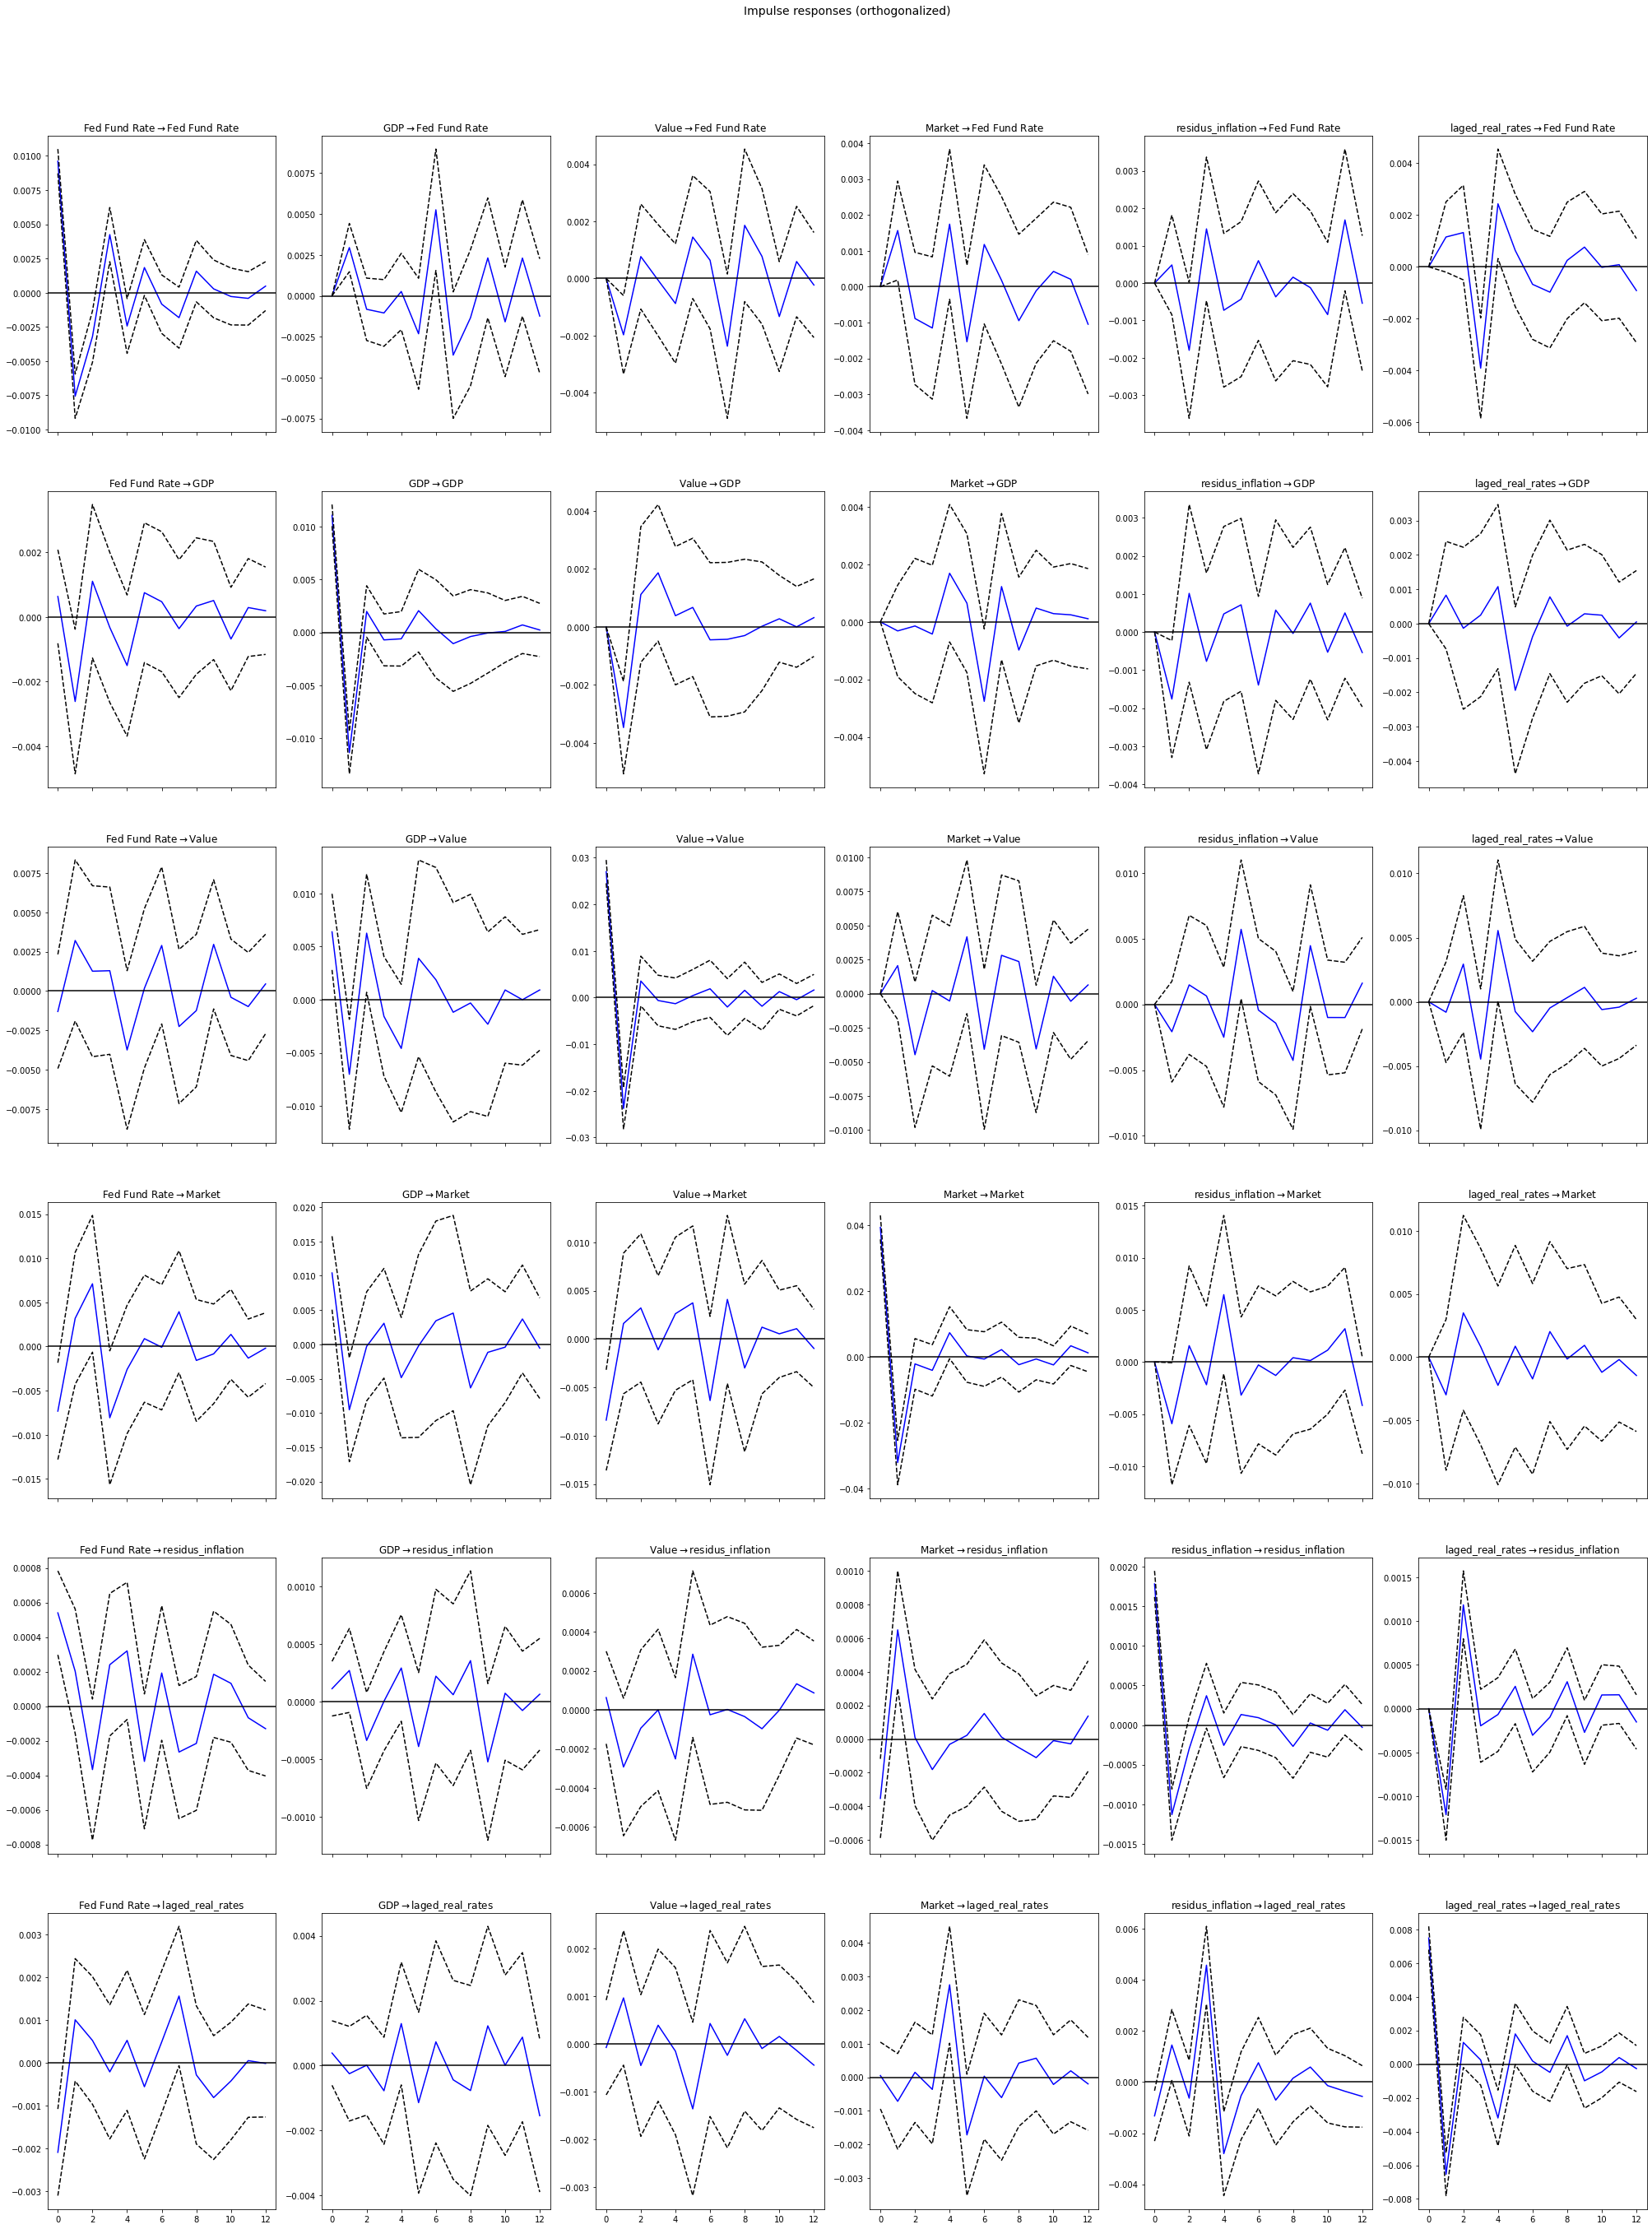

<Figure size 2880x2880 with 0 Axes>

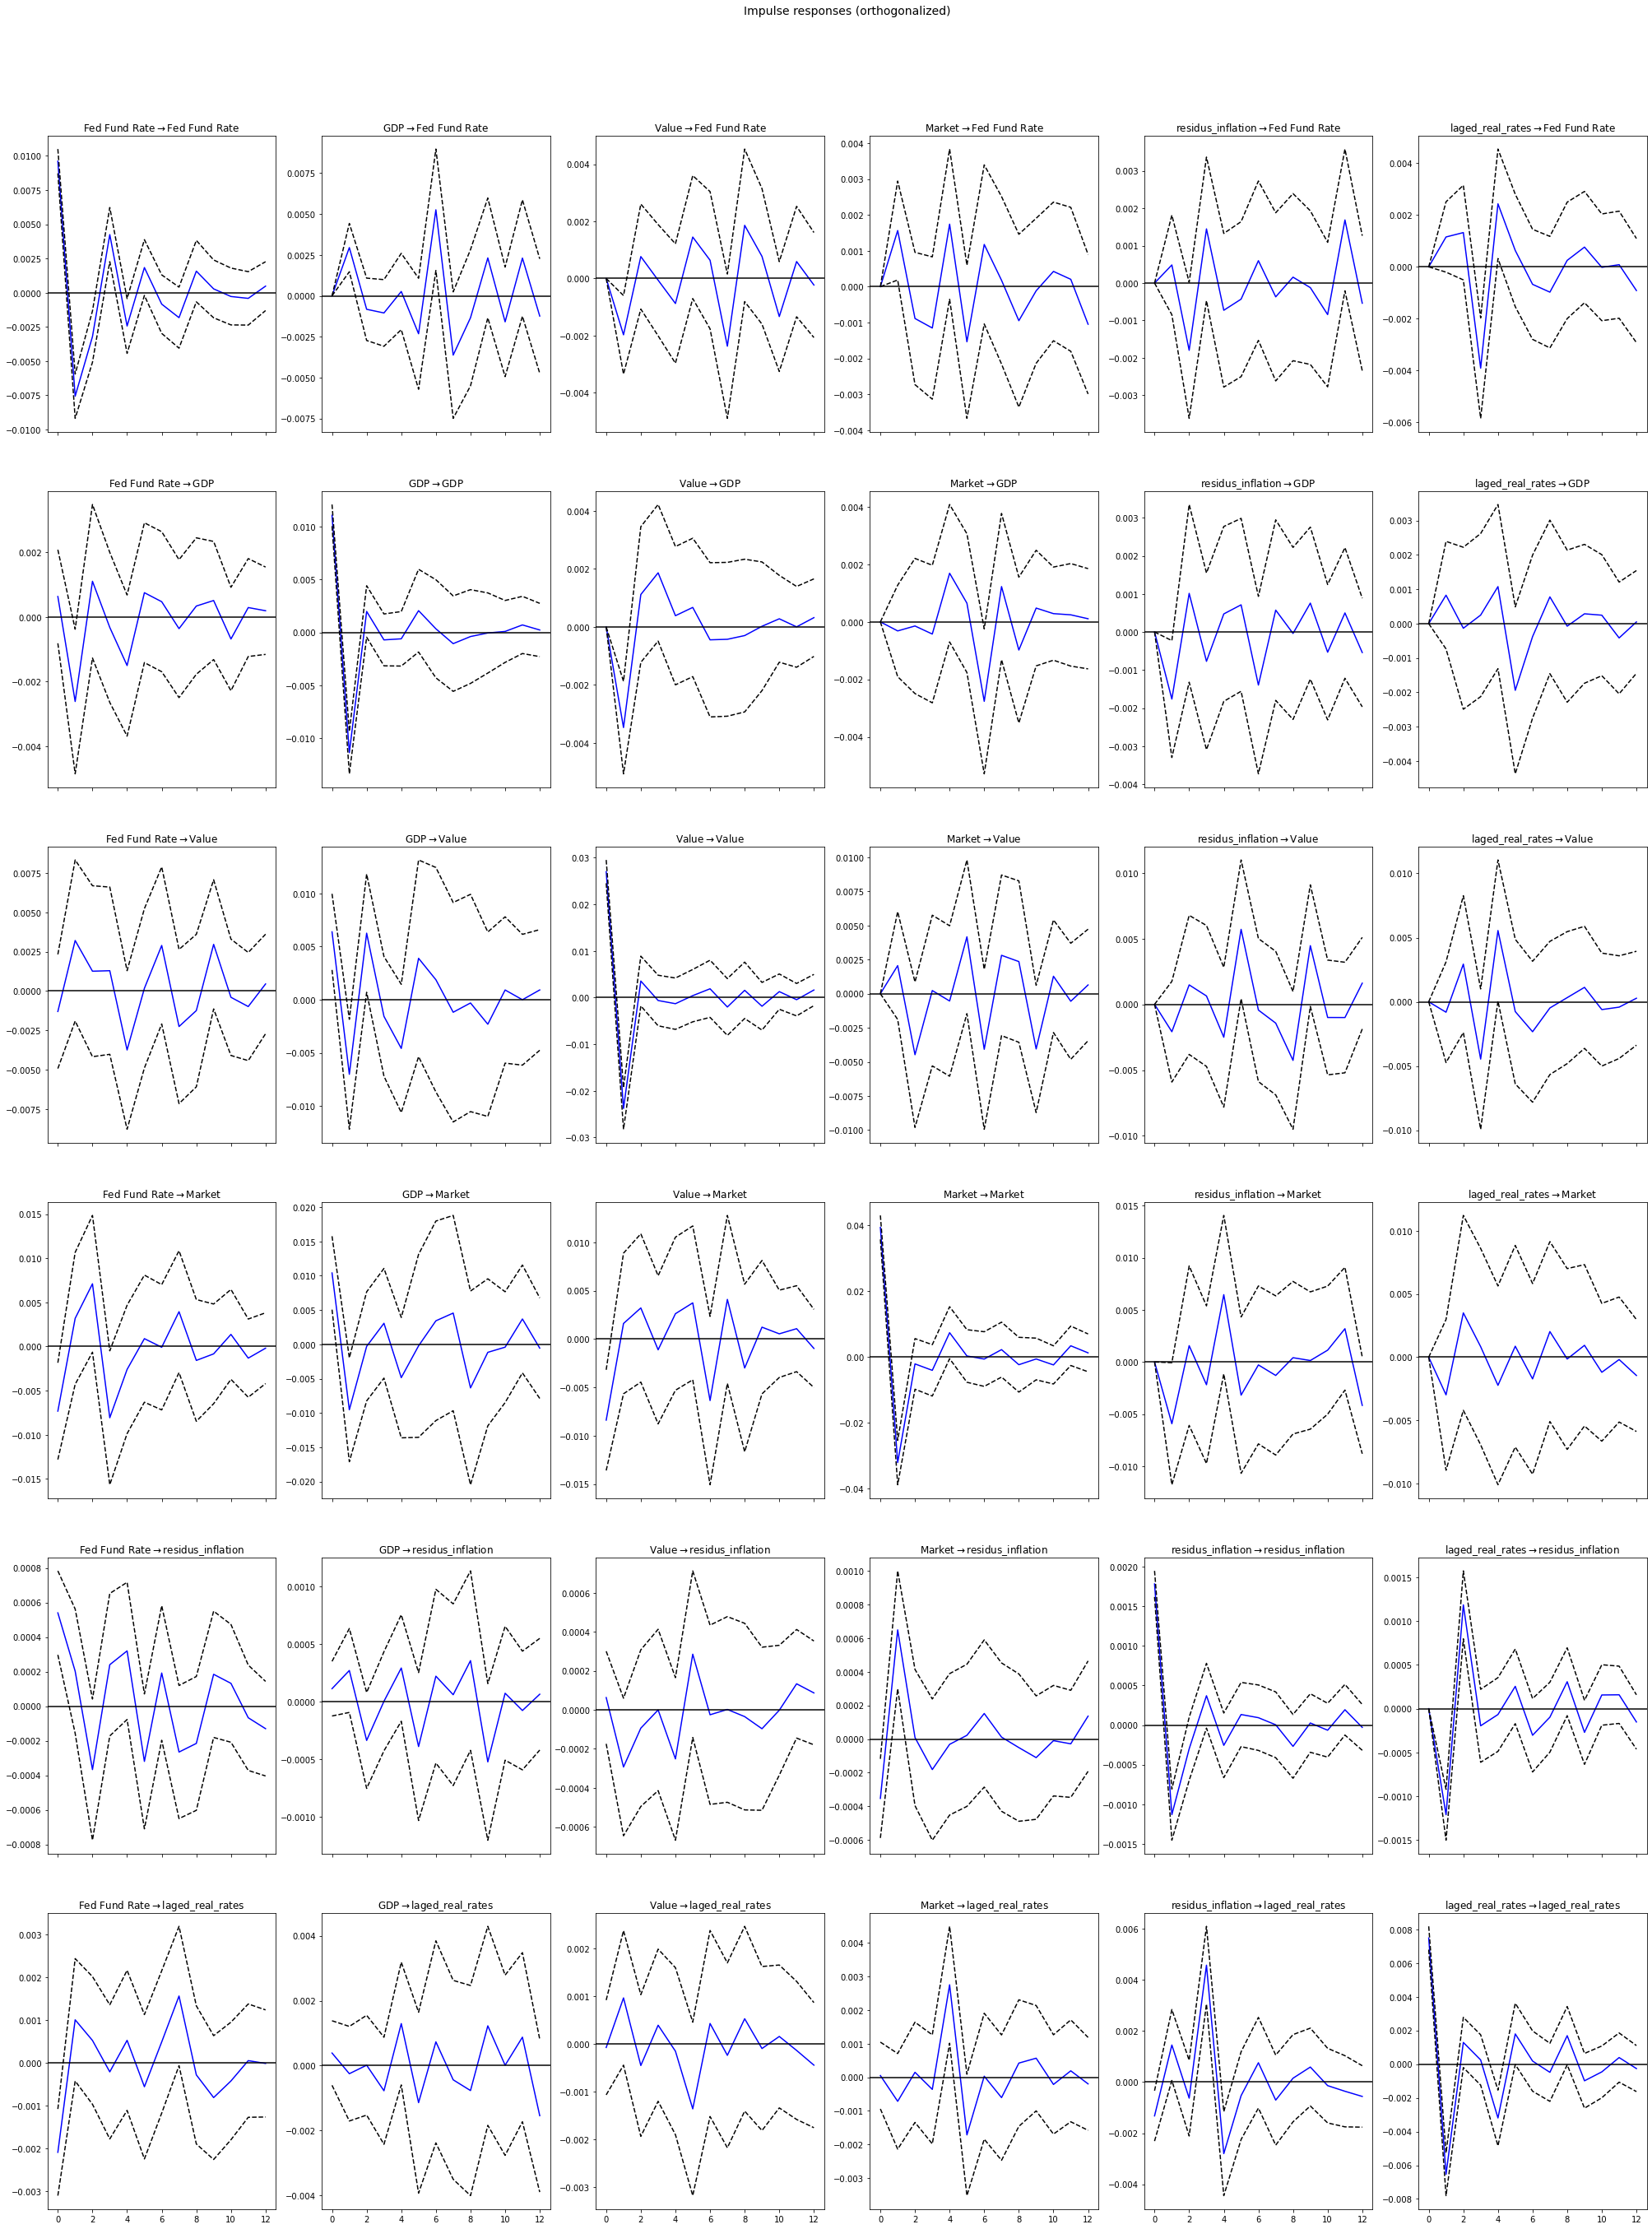

In [31]:
irf = model_fitted.irf(12)

plt.figure(figsize=(40,40))
irf.plot(orth=True, figsize=(30,40))

> On voit sur ces graphiques les fonctions de réponse des séries. Les lignes bleues sont les réponses impulsionnelles moyennes des séries face à un choc sur un autre série. Les lignes en pointillets noirs sont l'intervale de confiance : si 0 est comprit dans ce intervale de confiance, on dira que la réponse n'est pas significative suite à choc. 
Par exemple, les surpises d'inflations ne sont significativement impactées que par le marché jusqu'au lag 2, elles-mêmes jusqu'au lag 3 et les taux réels à 10 ans différenciés jusqu'au lag 4.

> <b><FONT size="4" color='teal'>Question 2</FONT>
>> Dans le cas spécifique des surprises d'inflation, que pouvez vous déduire de vos résultats? Répondez dans le contexte de la situation actuelle de l'économie mondiale. Quelle doit être la réaction de la banque centrale? Quel conseil pouvez vous lui donner pour l'aider à traverser la situation actuelle?

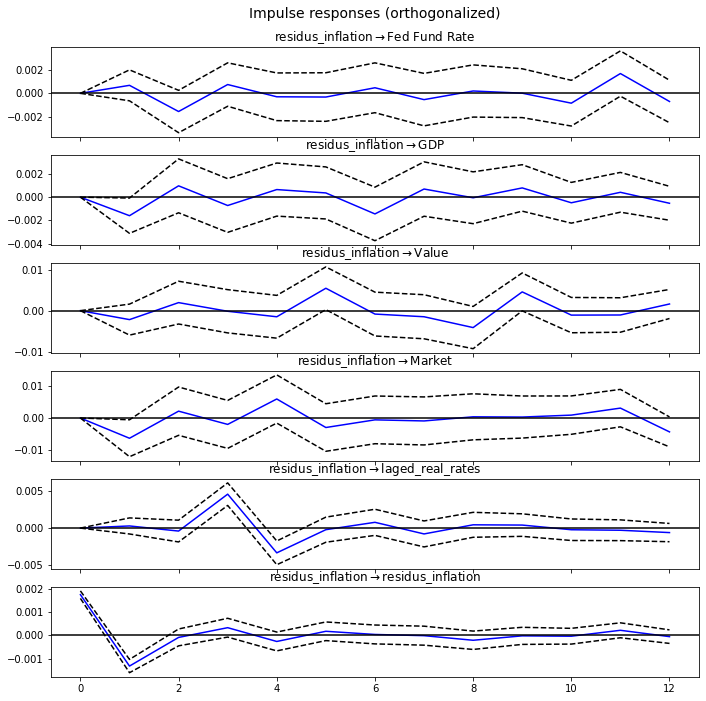

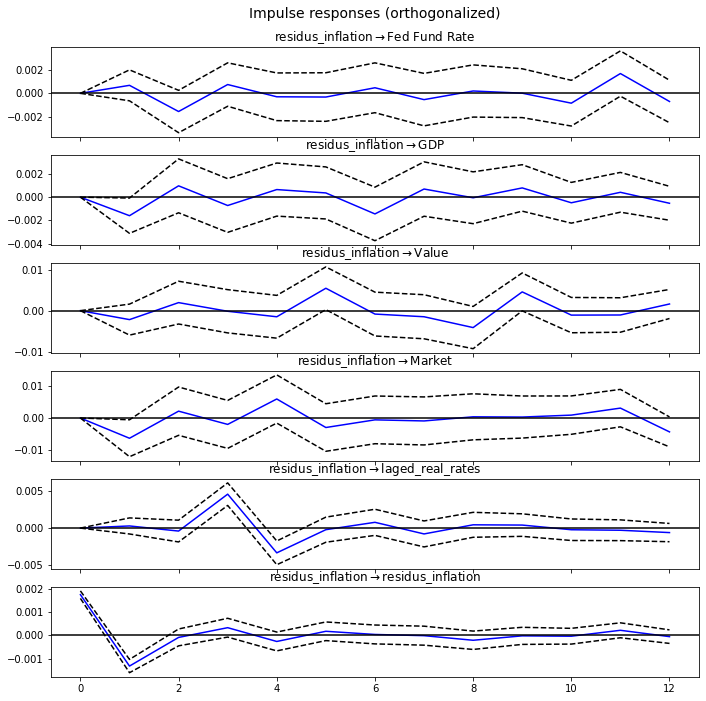

In [202]:
irf.plot(impulse = 'residus_inflation', orth=True)

> On considère sur les graphiques ci-dessus l'amplitude d'un choc de surprise d'inflation sur 12 périodes (soit 12 trimestres). 
>> On constate qu'après un choc en période 0, les variations trimestrielles du taux d’intérêt directeur de la Fed ne sont pas significativement impactées.  

>> Le PIB américain baisse significativement en première période après une suprirse d'inflation, mais n'est pas significativement impacté lors des autres périodes. 

>>Lorsqu'on observe la réponse des surprises d'inflation à un choc sur les surprises d'inflation, on constate qu'elles vont connaitre une baisse en période 1 et retourner à leurs niveau initial en période 4, indiquant une mémoire courte. 

>> La variable des taux réels à 10 ans laggués est significativement impactée par un choc sur les suprises d'inflation des lags 2 à 4, signifiant qu'une surpise d'inflation aujourd'hui aura un impact sur cette variable dans deux trimestres, et ce pendant 6 mois. 

> Pour la banque centrale, une reprise de l'inflation est à éviter. Or un choc des surpises d'inflation à la hausse indique une mauvaise estimation de l'inflation et donc une augmentation non-anticipée de cette dernière. Afin de tempérer la poussée inflationniste, la FED peut augmenter les taux d'intérêts. Cela viendra ralentir la demande en impactant les coûts d'emprunt. On voit sur les IRF précédents qu'un choc à la hausse des Fed Fund Rate vient baisser significativement les suprises d'inflation. 

> C'est d'ailleurs le phénomène que nous avons observé sur les courbes d'inflation précédemment : en 1980, afin de réduire l'inflation la FED avait augmenté le taux directeur à 20% et cela a permit de réduire l'inflation par la suite. 

> <b><FONT size="4" color='teal'>Question 3</FONT>
>>  Même question pour un gérant de portefeuille action. Expliquez ce que sont les actions "value", par opposition à "growth". Que recommandez vous au gérant action en cas de surprise d'inflation?

> Les actions dites "value" sont des actions momentanément décôtées, dont la valeur de la cotation boursière du titre est inférieure à sa valeur intrinsèque. 

> Une action "growth" a au contraire une croissance régulière. 

> Pour un gérant de portefeuille action, l'investissement dans des actions value sera une démarche dite défensive, qui vient anticiper une revalorisation du cours de l'action à sa juste valeur. 
L'invistissement dans des actions growth sera basé sur des sociétés bien valorisées et dont le gérant peut anticipier une hausse future de l'action. 

> En cas d'inflation, les actions growth sont fortement impactées car leur valorisation est particulièrement impactée par les flux trésoriers estimés de façon plutôt lointaine. 

> Les actions value sont, comme énoncé précédemment, dévalorisées. Les opérateurs n'attendant une croissance à long terme, elles apportent une duration plus faible que les actions growth. Ainsi, en période d'inflation, il est préférable d'opter pour les actions values.  

> De plus, on constate que la variable Value n'est pas significativement impactée par un choc des surpises d'inflation, lorsque la variable Market l'est significativement et négativement pendant le premier semestre suivant ce choc. 

> Finalement, il est toujours préférable de différencier son portefeuille d'action, cependant nous recommanderions au gérant d'investir en majorité dans des actions value en cas d'inflation.  